## Setup, Loading Data and CDFs

In [ ]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_diagonal_wavelet_full_spaceNet.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/full/wavelet/diagonal/blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 13604,
 3: 54416,
 4: 166649,
 5: 574769,
 6: 2125625,
 7: 8502500,
 8: 34010000,
 9: 136040000}

Running 12760 CDFs


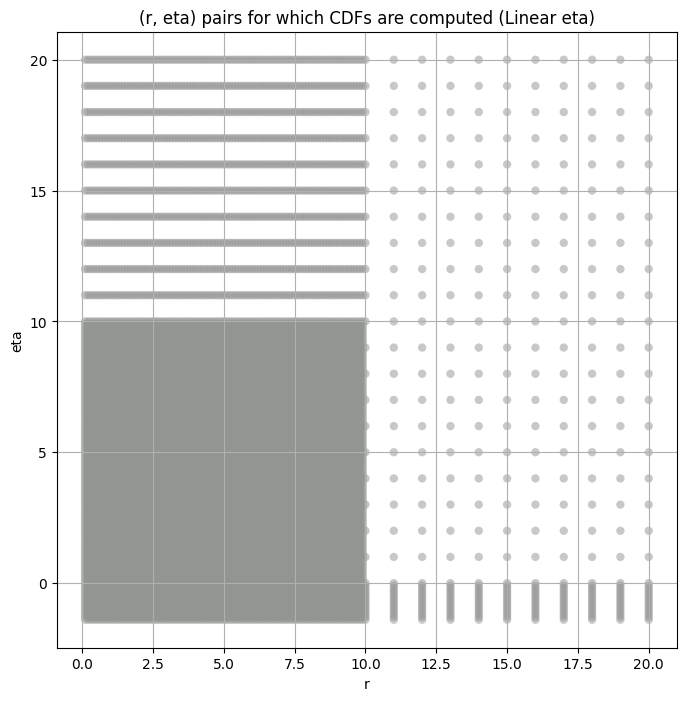

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
layer                                                                  
2      8170.624000  7603.631000  8790.542000    5.929228    3.575073   
3      1199.229000  1082.808500  1330.098100   14.136646    9.365142   
4       498.488830   450.375400   553.119700   13.649828    8.367245   
5       131.818250   119.407360   146.135670   13.324366    8.178824   
6        30.274773    27.387175    33.932415   15.115324    7.801616   
7         6.843550     6.050580     8.027263   27.543734   10.875002   
8         1.495765     1.261325     2.054993   94.259570   14.907044   
9         0.266803     0.216369     0.452525  294.651460   12.190354   

        kurt_upper  total_samples  
layer                              
2        10.276577        13604.0  
3        21.132668        54416.0  
4        26.794820       166649.0  
5        30.260353       574769.0  
6        46.193558      2125625.0  
7       106.769240      8502500.0  
8       424.218260     34010000.0  
9      1032.527700    136040000.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      8170.624000    8170.624023     7285.931152     6833.496582   
3      1199.229000    1199.229004     1110.487549     1063.913086   
4       498.488830     498.488831      474.266602      461.572021   
5       131.818250     131.818253      125.594559      122.237839   
6        30.274773      30.274773       28.733955       27.952858   
7         6.843550       6.843550        6.372661        6.157483   
8         1.495765       1.495765        1.330572        1.272083   
9         0.266803       0.266803        0.226088        0.216667   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         6481.379395      6191.449707      5732.119141      5360.634766   
3         1028.659424       997.898621       946.179626       903.198303   
4          451.131500       442.168976       426.730743       413.693207   
5          119.554153       117.228615       113.229256       109.817802   
6           27.332533        26.803587        25.908079        25.152689   
7            5.988860         5.845915         5.606984         5.408049   
8            1.228225         1.192130         1.133597         1.086259   
9            0.209822         0.204277         0.195385         0.188256   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          5043.900391      4765.612305      4519.788574      3902.939453  
3           865.813477       832.332642       802.030579       724.930481  
4           402.415070       392.260376       382.916321       358.808533  
5           106.809555       104.106804       101.645477        95.299004  
6            24.490606        23.896061        23.352762        21.946856  
7             5.235572         5.082644         4.944625         4.594183  
8             1.046102         1.011033         0.979777         0.901975  
9             0.182230         0.176970         0.172282         0.160571

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.01245187136237913 8170.624


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.013235922567270575 7285.931


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.016982333237888114 6833.4966


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.017184968814844437 6481.3794


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.017384994501423612 6191.4497


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.019459543375743737 5732.119


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.02140087536587082 5360.635


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.02461016358980793 5043.9004


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.02834107415518801 4765.6123


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.0322006137673808 4519.7886


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.043854195338621726 3902.9395
Number of samples: 13604, Without approximation : 13604.0


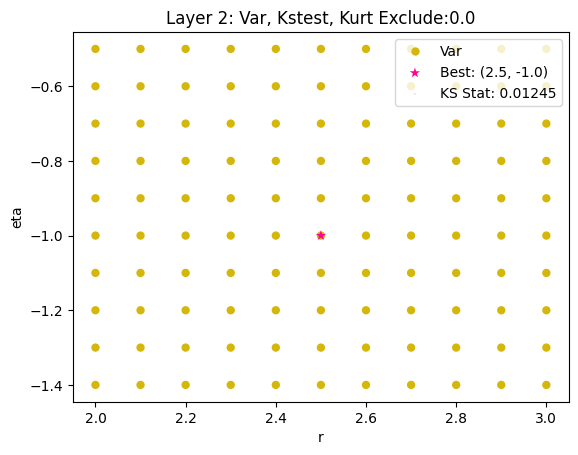

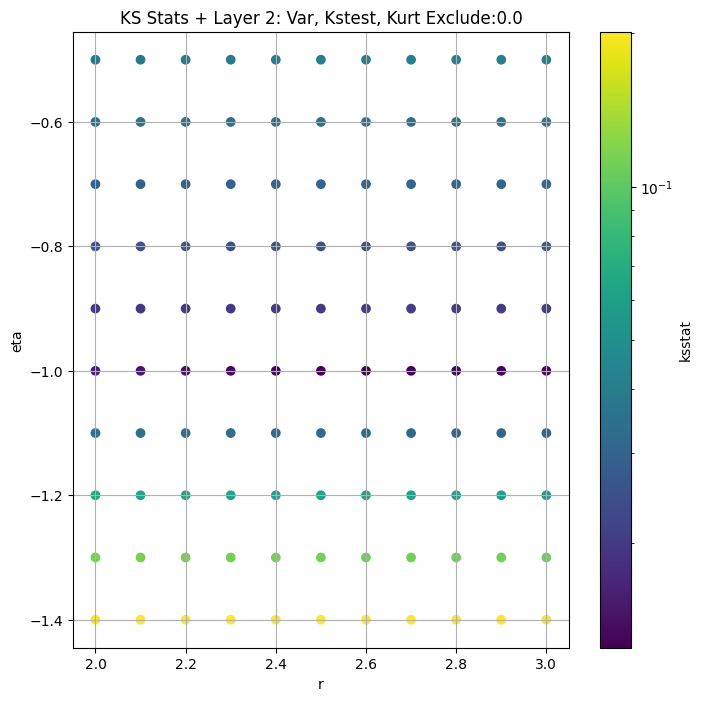

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.222067039106145 1199.229


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.222067039106145 1110.4875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.222067039106145 1063.9131


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.222067039106145 1028.6594


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.222067039106145 997.8986


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.222067039106145 946.1796


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.222067039106145 903.1983


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.222067039106145 865.8135


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.222067039106145 832.33264


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.222067039106145 802.0306


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.222067039106145 724.9305
Number of samples: 54416, Without approximation : 54416.0


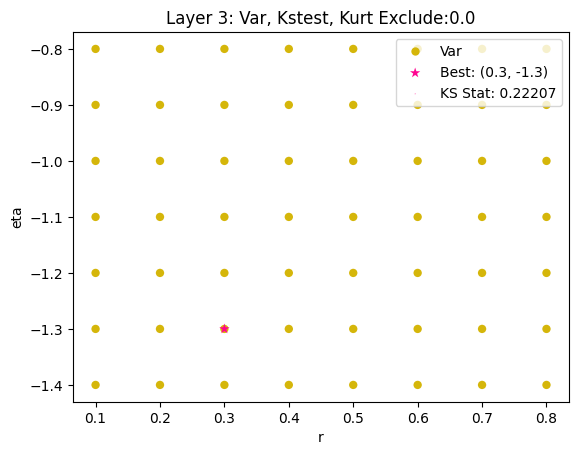

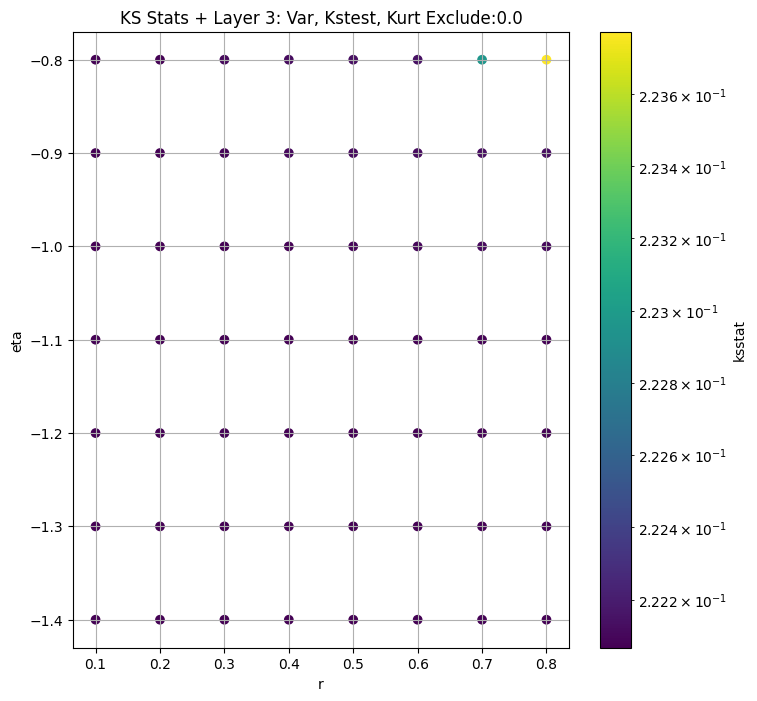

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.13268999999999975 498.48883


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.13268999999999975 474.2666


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.13268999999999975 461.57202


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.13268999999999975 451.1315


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.13268999999999975 442.16898


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.13268999999999975 426.73074


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.13268999999999975 413.6932


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.13268999999999975 402.41507


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.13268999999999975 392.26038


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.13268999999999975 382.91632


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.13268999999999975 358.80853
Number of samples: 100000, Without approximation : 166649.0


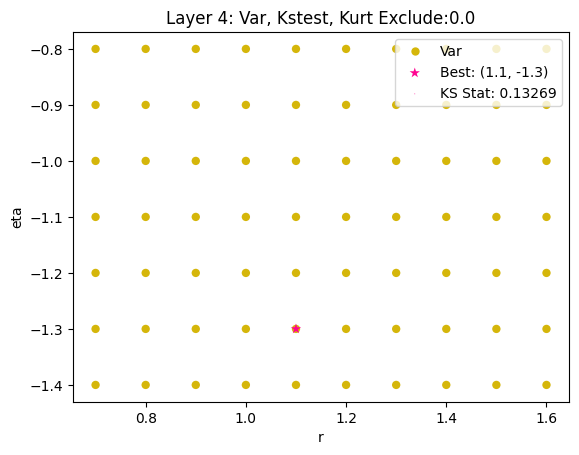

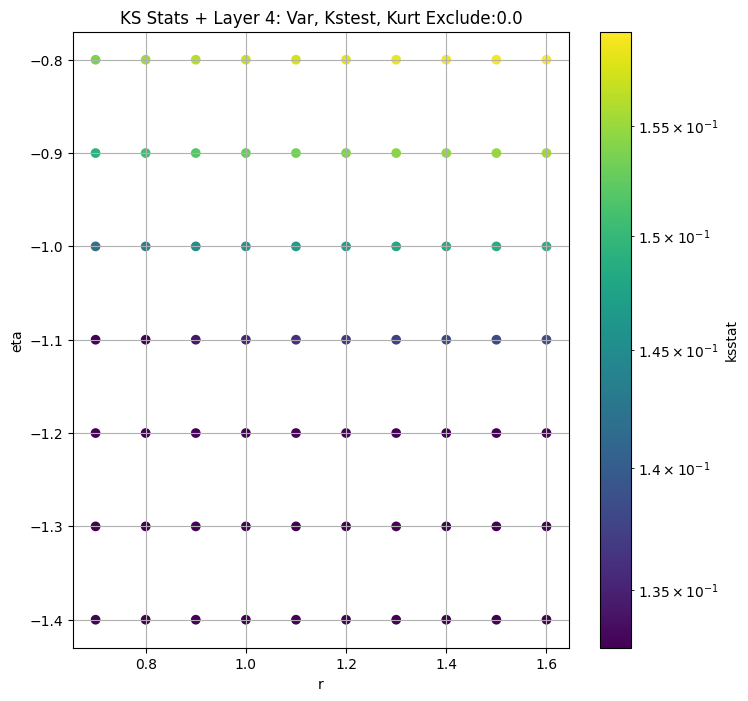

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.07416999999999979 131.81825


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.07416999999999979 125.59456


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.07416999999999979 122.23784


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.07416999999999979 119.55415


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.07416999999999979 117.228615


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.07416999999999979 113.229256


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.07416999999999979 109.8178


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.07416999999999979 106.809555


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.07416999999999979 104.106804


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.07416999999999979 101.64548


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.07416999999999979 95.299
Number of samples: 100000, Without approximation : 574769.0


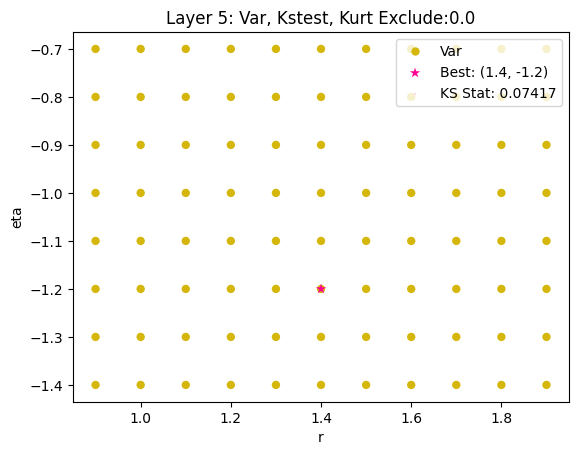

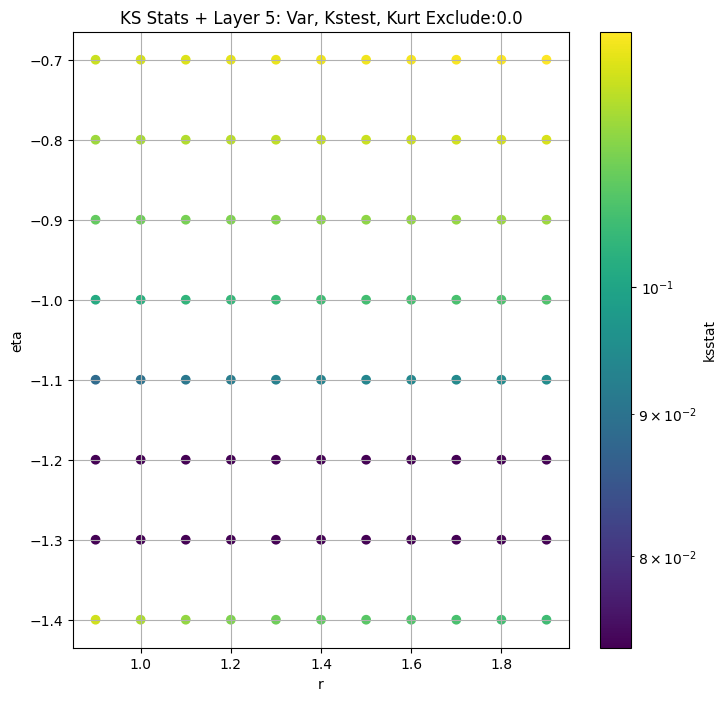

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.008590600085761568 30.274773


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.008778200842465389 28.733955


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.008617847162878667 27.952858


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.00879984315622373 27.332533


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.008945940400679808 26.803587


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.008836493655176691 25.90808


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.008866497977330023 25.152689


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.008903001265345212 24.490606


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.008996828431591664 23.89606


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.009005101315860964 23.352762


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.00904239944157803 21.946856
Number of samples: 100000, Without approximation : 2125625.0


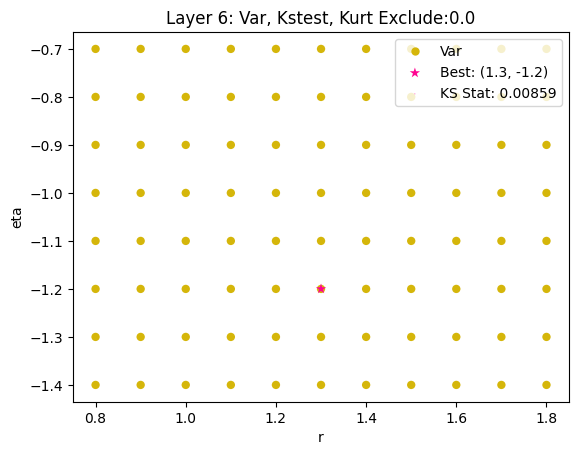

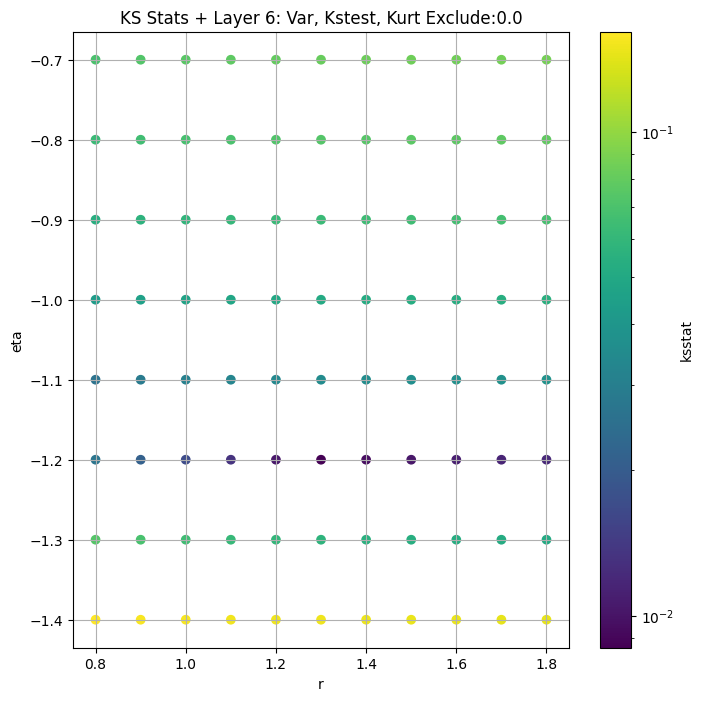

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.009600922953132196 6.84355


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.011658600890771753 6.372661


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.012906821868529705 6.1574826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.011856438389596102 5.9888597


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.010951662809046914 5.845915


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.009395969415497751 5.606984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.010977409172571617 5.408049


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.012902665739636165 5.235572


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.013676348683386685 5.0826445


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.01264836289629706 4.9446254


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.01436235717933898 4.594183
Number of samples: 100000, Without approximation : 8502500.0


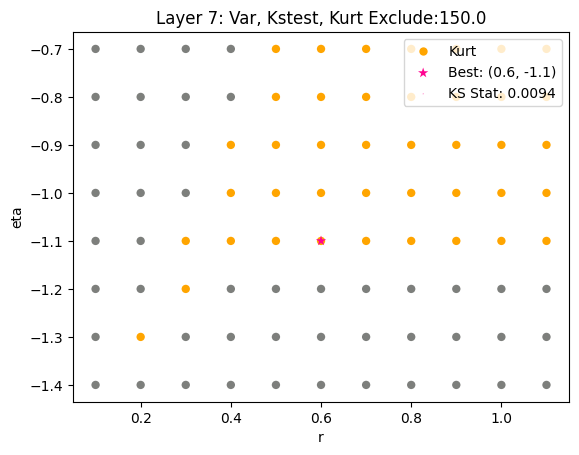

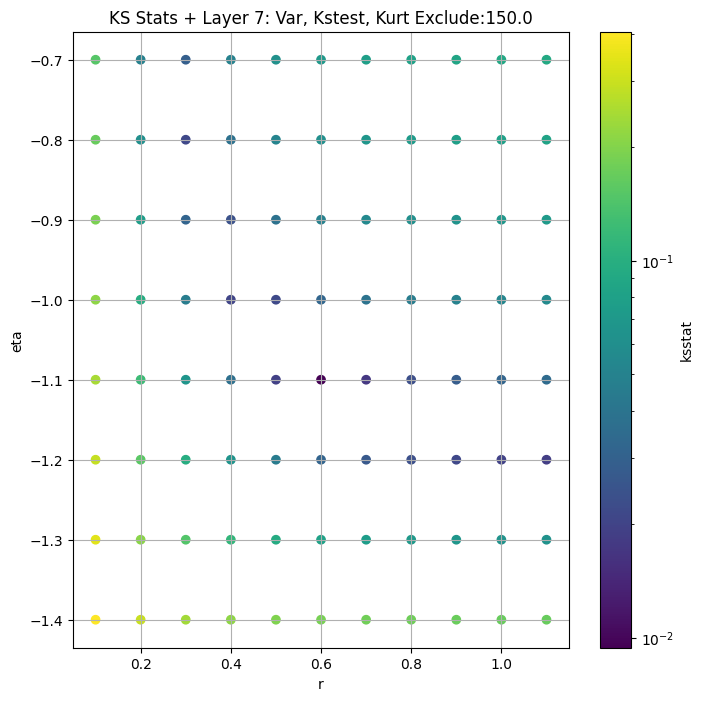

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.00795303515904855 1.4957647


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.0079272975085794 1.3305721


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.006831462102706576 1.2720827


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.008609120926801883 1.2282254


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.009664051361083226 1.19213


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.00990490070540706 1.1335965


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.009848114629795013 1.0862589


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.009222773976645726 1.0461019


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.009025801496808872 1.0110332


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.009786980757027774 0.9797772


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.012465337182677394 0.9019746
Number of samples: 100000, Without approximation : 34010000.0


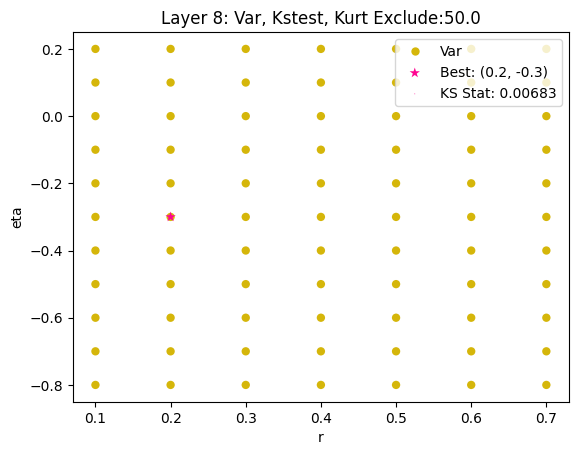

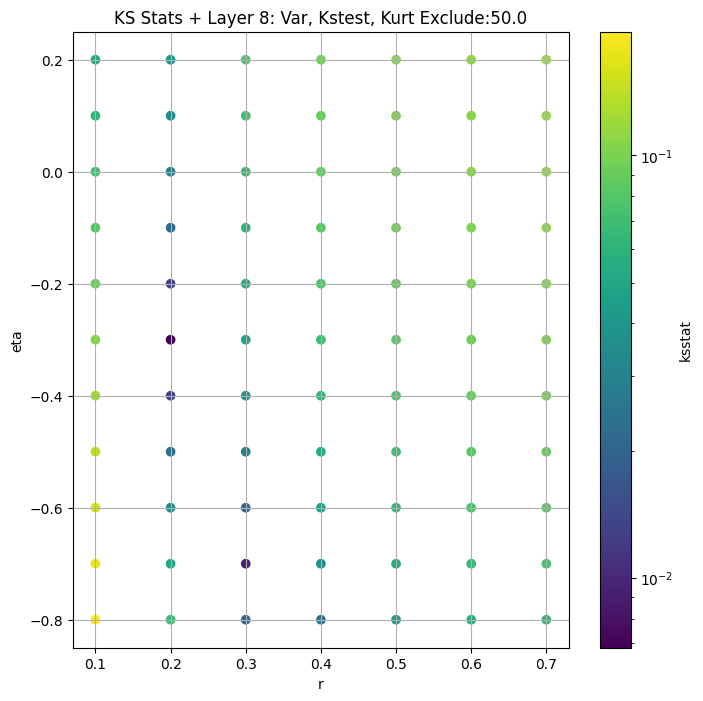

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.008682996341011162 0.26680335


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.008445366771427265 0.22608832


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.008679882147655915 0.21666674


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.008653388745159252 0.20982204


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.008406659512816939 0.20427723


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.008365753960058564 0.19538502


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.008453417511936512 0.18825646


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.00870704795624927 0.18222995


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.008416423632503667 0.17696962


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.008323743141074313 0.17228194


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.009268146287846002 0.16057052
Number of samples: 100000, Without approximation : 136040000.0


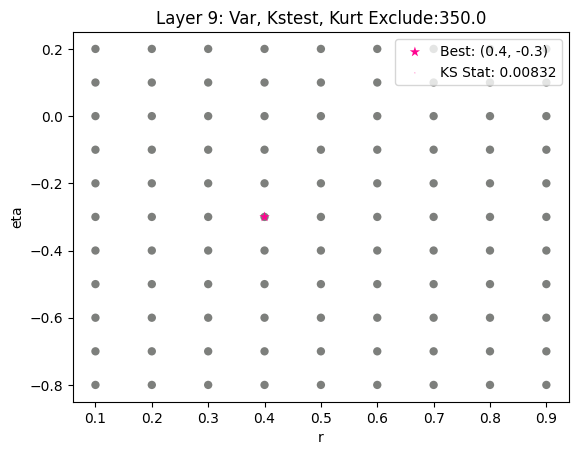

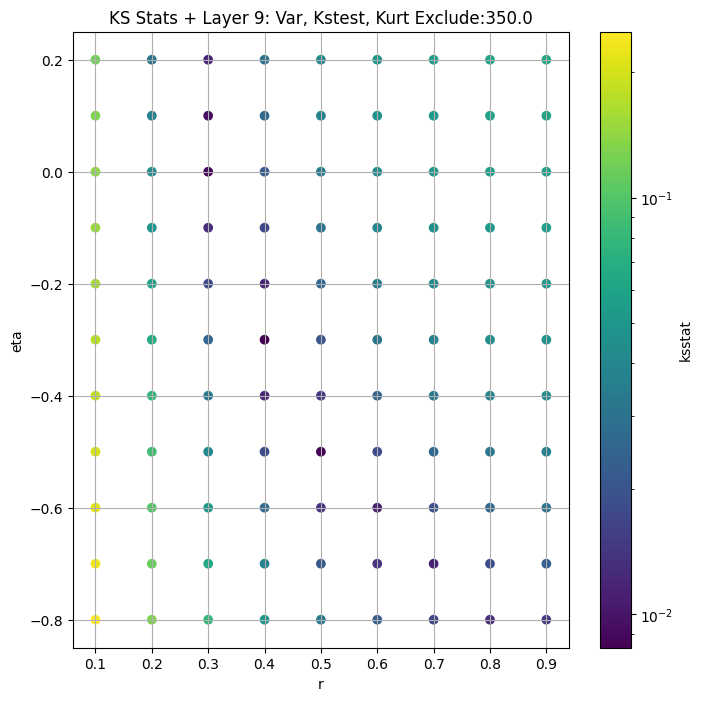

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
layer                                                                  
2      8170.624000  7603.631000  8790.542000    5.929228    3.575073   
3      1199.229000  1082.808500  1330.098100   14.136646    9.365142   
4       498.488830   450.375400   553.119700   13.649828    8.367245   
5       131.818250   119.407360   146.135670   13.324366    8.178824   
6        30.274773    27.387175    33.932415   15.115324    7.801616   
7         6.843550     6.050580     8.027263   27.543734   10.875002   
8         1.495765     1.261325     2.054993   94.259570   14.907044   
9         0.266803     0.216369     0.452525  294.651460   12.190354   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2        10.276577        13604.0             0.012452        2.5   
3        21.132668        54416.0             0.222067        0.3   
4        26.794820       166649.0             0.132690        1.1   
5        30.260353       574769.0             0.074170        1.4   
6        46.193558      2125625.0             0.008591        1.3   
7       106.769240      8502500.0             0.009396        0.6   
8       424.218260     34010000.0             0.006831        0.2   
9      1032.527700    136040000.0             0.008324        0.4   

       initial_eta  initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                                           
2             -1.0   25188.190411                     0.0         8170.624000   
3             -1.3     270.649585                     0.0         1199.229000   
4             -1.3    2650.178029                     0.0          498.488830   
5             -1.2     537.492655                     0.0          131.818250   
6             -1.2     119.459465                     0.0           30.274773   
7             -1.1       6.376841                   150.0            5.606984   
8             -0.3       0.000042                    50.0            1.272083   
9             -0.3       0.006583                   350.0            0.172282   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.011632  
3                     0.005819  
4                     0.003326  
5                     0.001791  
6                     0.000931  
7                     0.000466  
8                     0.000233  
9                     0.000116

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.018810755946921276, var: 6191.44970703125


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.017184968814844437, var: 6481.37939453125


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.01737996939577896, var: 6833.49658203125


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.01820709565383638, var: 7285.93115234375


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.01245187136237913, var: 8170.6240234375
Number of samples: 13604, Without approximation : 13604.0


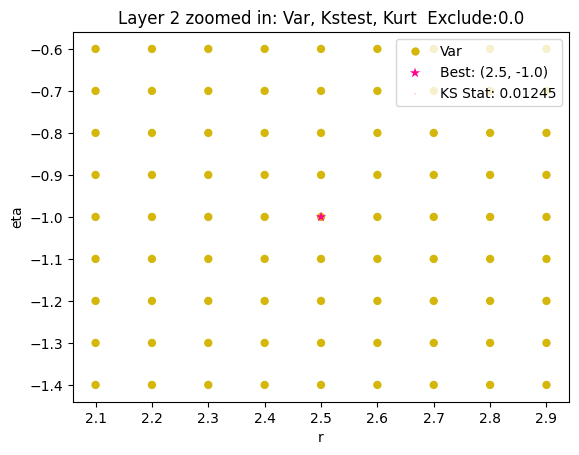

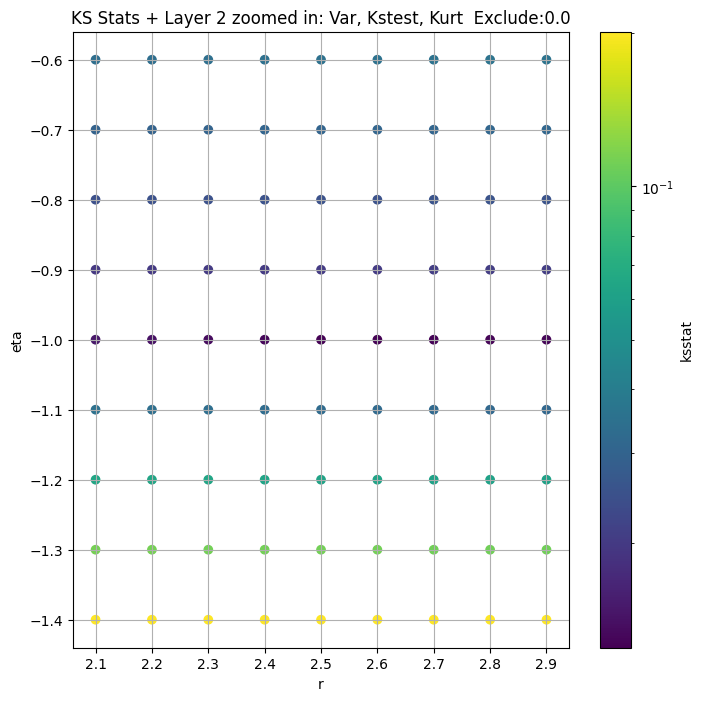

Layer 3


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.222067039106145, var: 997.8986206054688


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.222067039106145, var: 1028.659423828125


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.222067039106145, var: 1063.9130859375


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.222067039106145, var: 1110.487548828125


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.222067039106145, var: 1199.22900390625
Number of samples: 54416, Without approximation : 54416.0


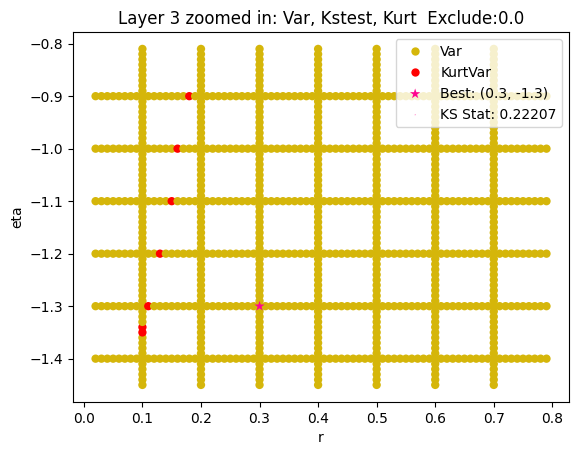

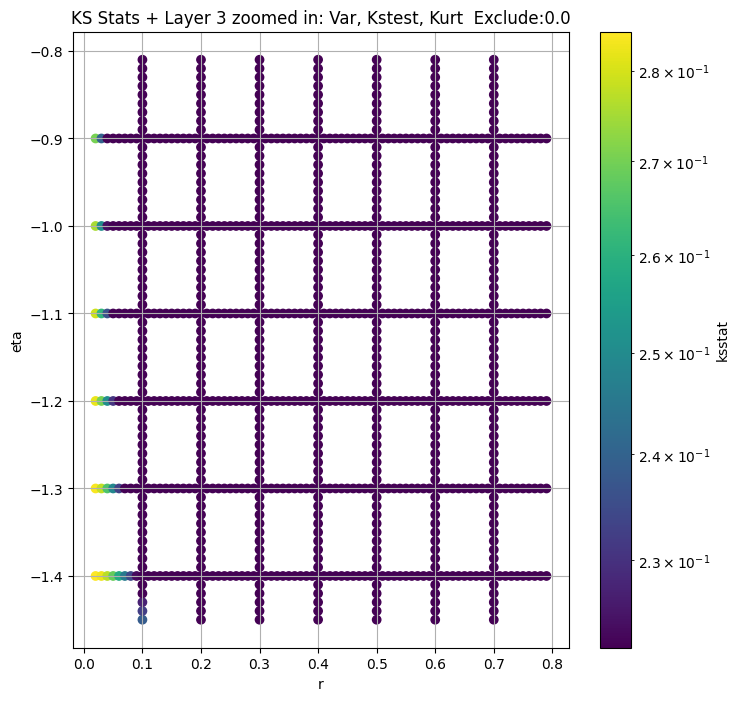

Layer 4


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.13268999999999975, var: 442.1689758300781


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.13268999999999975, var: 451.1315002441406


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.13268999999999975, var: 461.572021484375


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.13268999999999975, var: 474.2666015625


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.13268999999999975, var: 498.48883056640625
Number of samples: 100000, Without approximation : 166649.0


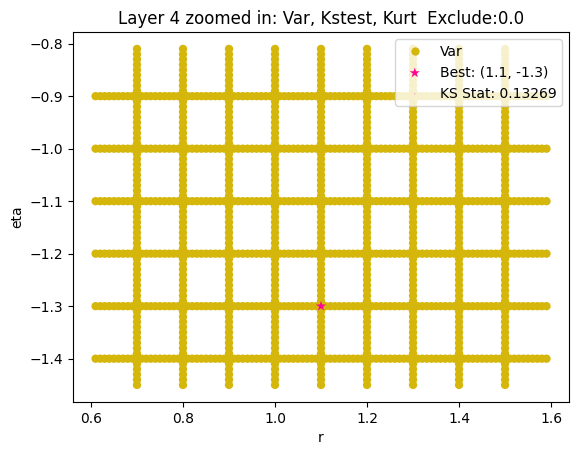

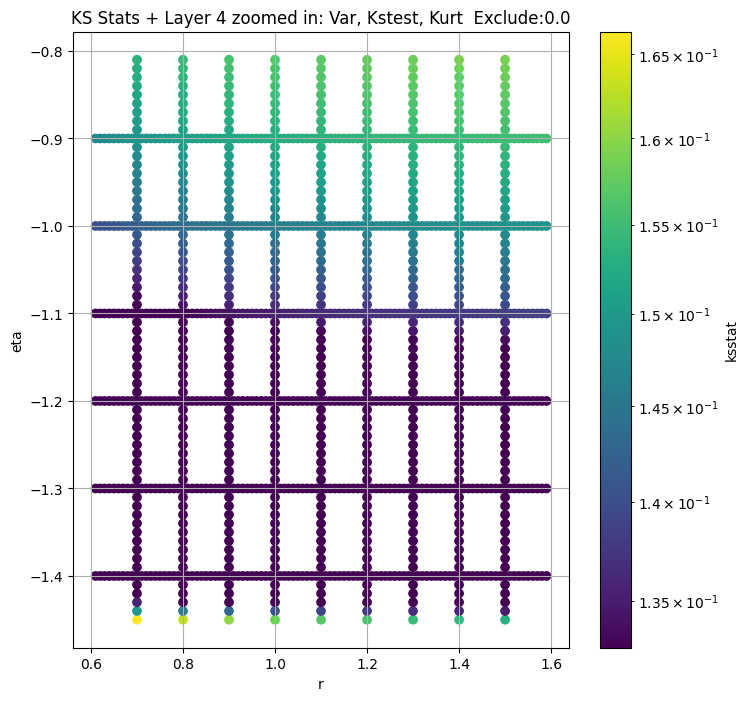

Layer 5


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.07416999999999974, var: 117.2286148071289


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.07416999999999974, var: 119.55415344238281


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.07416999999999974, var: 122.23783874511719


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.07416999999999974, var: 125.59455871582031


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.07416999999999974, var: 131.81825256347656
Number of samples: 100000, Without approximation : 574769.0


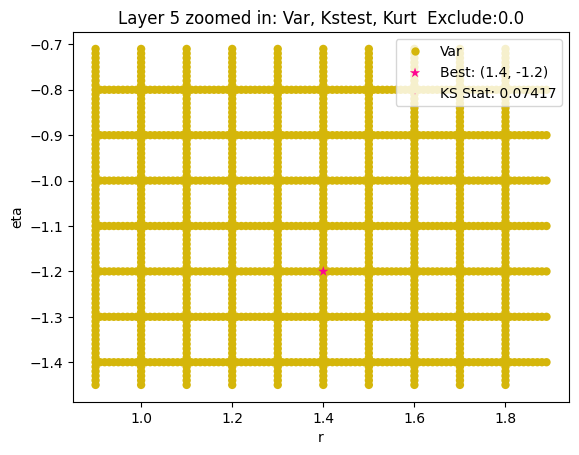

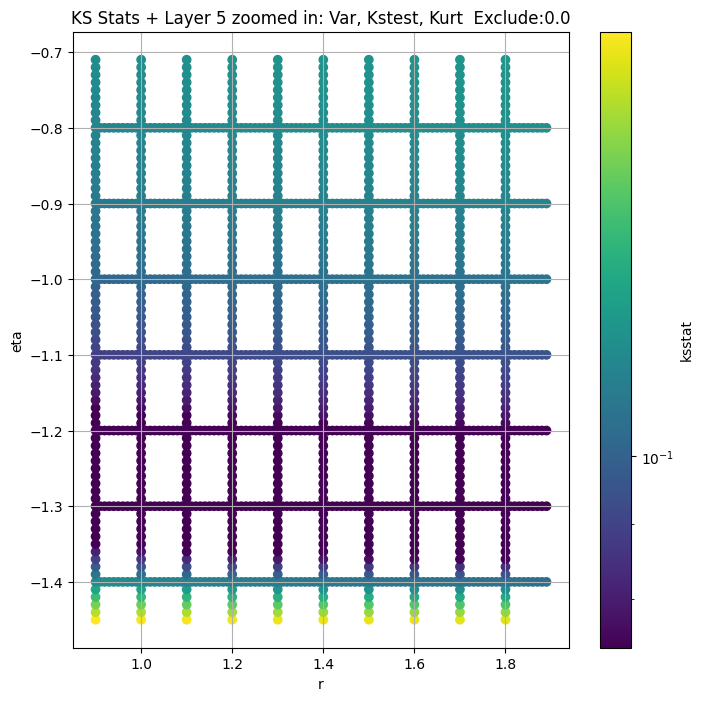

Layer 6


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.00869381674867531, var: 26.803586959838867


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.008678003201305517, var: 27.33253288269043


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.008617847162878667, var: 27.952857971191406


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.008587846986888414, var: 28.73395538330078


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.008488203609203604, var: 30.27477264404297
Number of samples: 100000, Without approximation : 2125625.0


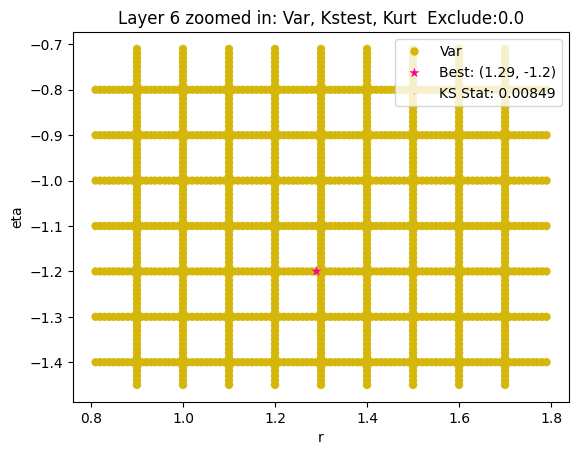

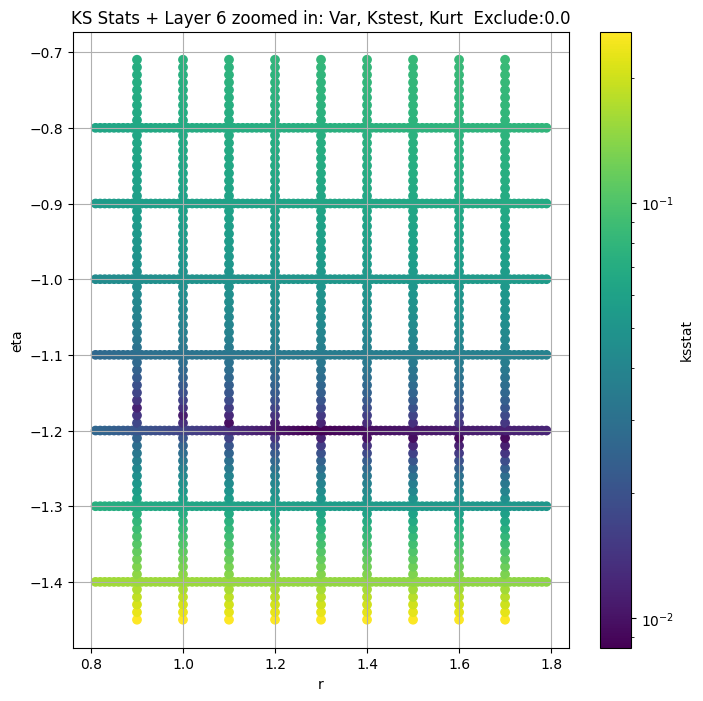

Layer 7


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + 100 = 250, ksstat: 0.009247953915571094, var: 5.23557186126709


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + 75 = 225, ksstat: 0.009844283884747673, var: 5.318987846374512


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + 50 = 200, ksstat: 0.009856778929328291, var: 5.4080491065979


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + 25 = 175, ksstat: 0.009621841603923986, var: 5.5036163330078125


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + 0 = 150, ksstat: 0.009395969415497751, var: 5.6069841384887695


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + -25 = 125, ksstat: 0.009129179968011547, var: 5.720194339752197


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + -50 = 100, ksstat: 0.008908233676176769, var: 5.845914840698242


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + -75 = 75, ksstat: 0.008529859000626971, var: 5.9888596534729


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + -100 = 50, ksstat: 0.008603682037912841, var: 6.157482624053955
Number of samples: 100000, Without approximation : 8502500.0


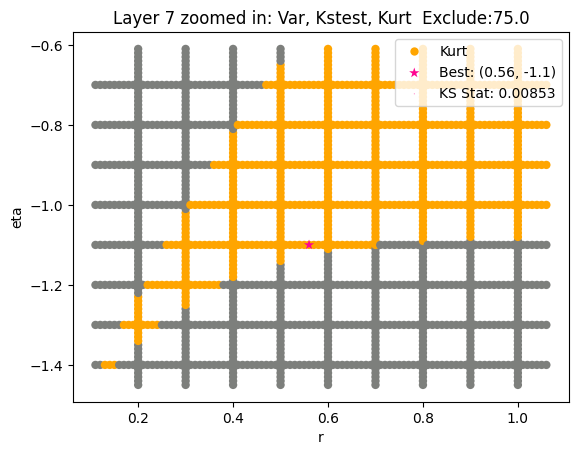

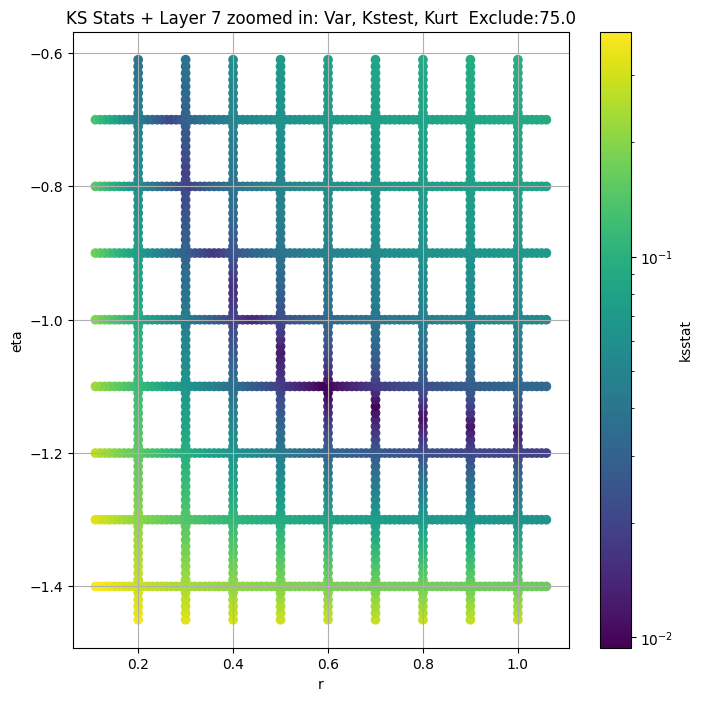

Layer 8


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 50.0 + 100 = 150, ksstat: 0.008040626657523864, var: 1.1335965394973755


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 50.0 + 75 = 125, ksstat: 0.007585731177127686, var: 1.161072015762329


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 50.0 + 50 = 100, ksstat: 0.007124330938433288, var: 1.1921299695968628


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 50.0 + 25 = 75, ksstat: 0.007285872014314909, var: 1.2282253503799438


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 50.0 + 0 = 50, ksstat: 0.006540688510734194, var: 1.2720826864242554


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 50.0 + -25 = 25, ksstat: 0.006613406106116493, var: 1.3305721282958984


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 50.0 + -50 = 0, ksstat: 0.006609281964326197, var: 1.4957647323608398
Number of samples: 100000, Without approximation : 34010000.0


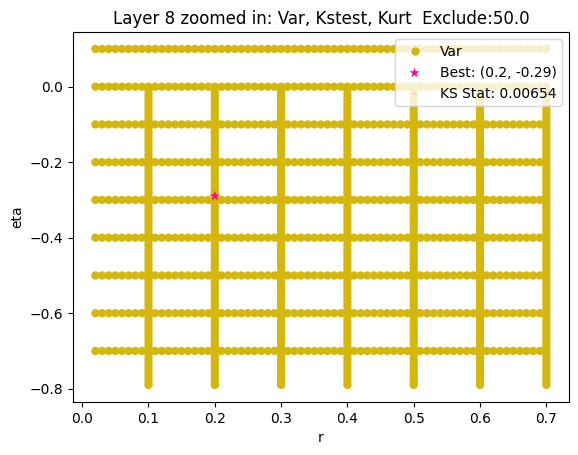

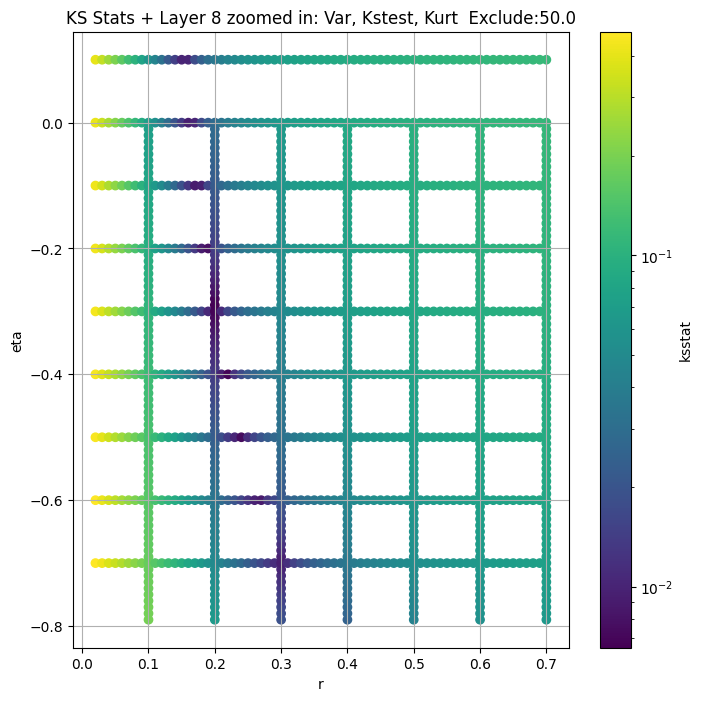

Layer 9


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + 100 = 450, ksstat: 0.008305911865518378, var: 0.1641562432050705


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + 75 = 425, ksstat: 0.008302428395573158, var: 0.16605710983276367


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + 50 = 400, ksstat: 0.008289225845869608, var: 0.16803954541683197


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + 25 = 375, ksstat: 0.008297390102687208, var: 0.17011135816574097


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + 0 = 350, ksstat: 0.008293203141240879, var: 0.17228193581104279


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + -25 = 325, ksstat: 0.008302393731959734, var: 0.17456306517124176


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + -50 = 300, ksstat: 0.008286610306786735, var: 0.17696961760520935


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + -75 = 275, ksstat: 0.008290370377394496, var: 0.17951825261116028


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + -100 = 250, ksstat: 0.008286985038455041, var: 0.18222995102405548
Number of samples: 100000, Without approximation : 136040000.0


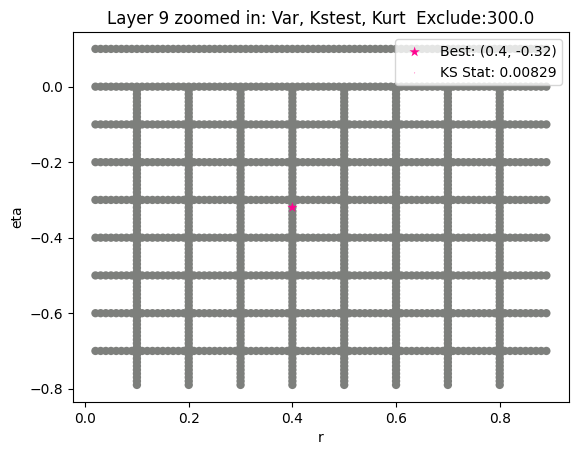

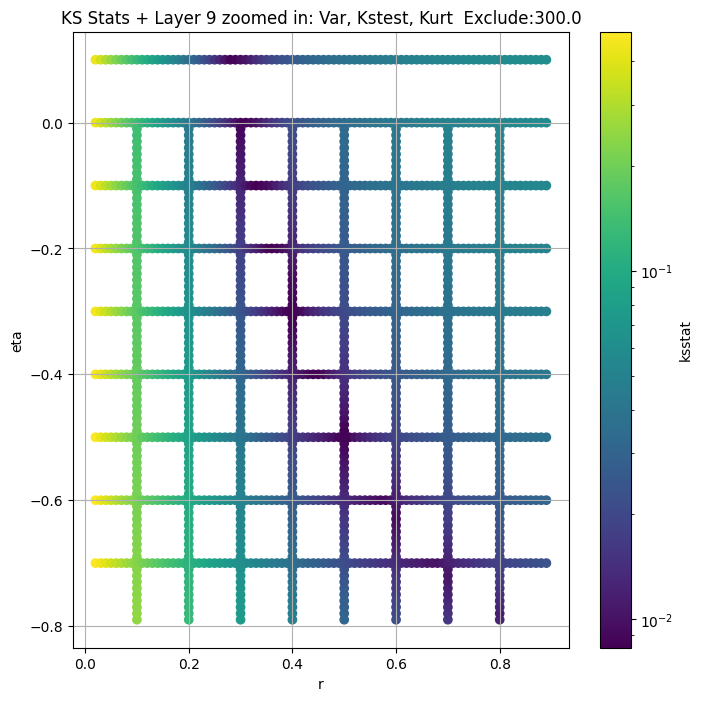

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
layer                                                                  
2      8170.624000  7603.631000  8790.542000    5.929228    3.575073   
3      1199.229000  1082.808500  1330.098100   14.136646    9.365142   
4       498.488830   450.375400   553.119700   13.649828    8.367245   
5       131.818250   119.407360   146.135670   13.324366    8.178824   
6        30.274773    27.387175    33.932415   15.115324    7.801616   
7         6.843550     6.050580     8.027263   27.543734   10.875002   
8         1.495765     1.261325     2.054993   94.259570   14.907044   
9         0.266803     0.216369     0.452525  294.651460   12.190354   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2        10.276577        13604.0             0.012452        2.5   
3        21.132668        54416.0             0.222067        0.3   
4        26.794820       166649.0             0.132690        1.1   
5        30.260353       574769.0             0.074170        1.4   
6        46.193558      2125625.0             0.008591        1.3   
7       106.769240      8502500.0             0.009396        0.6   
8       424.218260     34010000.0             0.006831        0.2   
9      1032.527700    136040000.0             0.008324        0.4   

       initial_eta  initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                                           
2             -1.0   25188.190411                     0.0         8170.624000   
3             -1.3     270.649585                     0.0         1199.229000   
4             -1.3    2650.178029                     0.0          498.488830   
5             -1.2     537.492655                     0.0          131.818250   
6             -1.2     119.459465                     0.0           30.274773   
7             -1.1       6.376841                   150.0            5.988860   
8             -0.3       0.000042                    50.0            1.272083   
9             -0.3       0.006583                   350.0            0.176970   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.011632          0.012452    2.50     -1.00   
3                     0.005819          0.222067    0.30     -1.30   
4                     0.003326          0.132690    1.10     -1.30   
5                     0.001791          0.074170    1.40     -1.20   
6                     0.000931          0.008488    1.29     -1.20   
7                     0.000466          0.008530    0.56     -1.10   
8                     0.000233          0.006541    0.20     -0.29   
9                     0.000116          0.008287    0.40     -0.32   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      25188.190411                  0.0        11478  
3        270.649585                  0.0           34  
4       2650.178029                  0.0          100  
5        537.492655                  0.0          315  
6        119.013126                  0.0        24909  
7          5.748521                 75.0        24909  
8          0.000041                 50.0        42033  
9          0.007000                300.0        28021

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

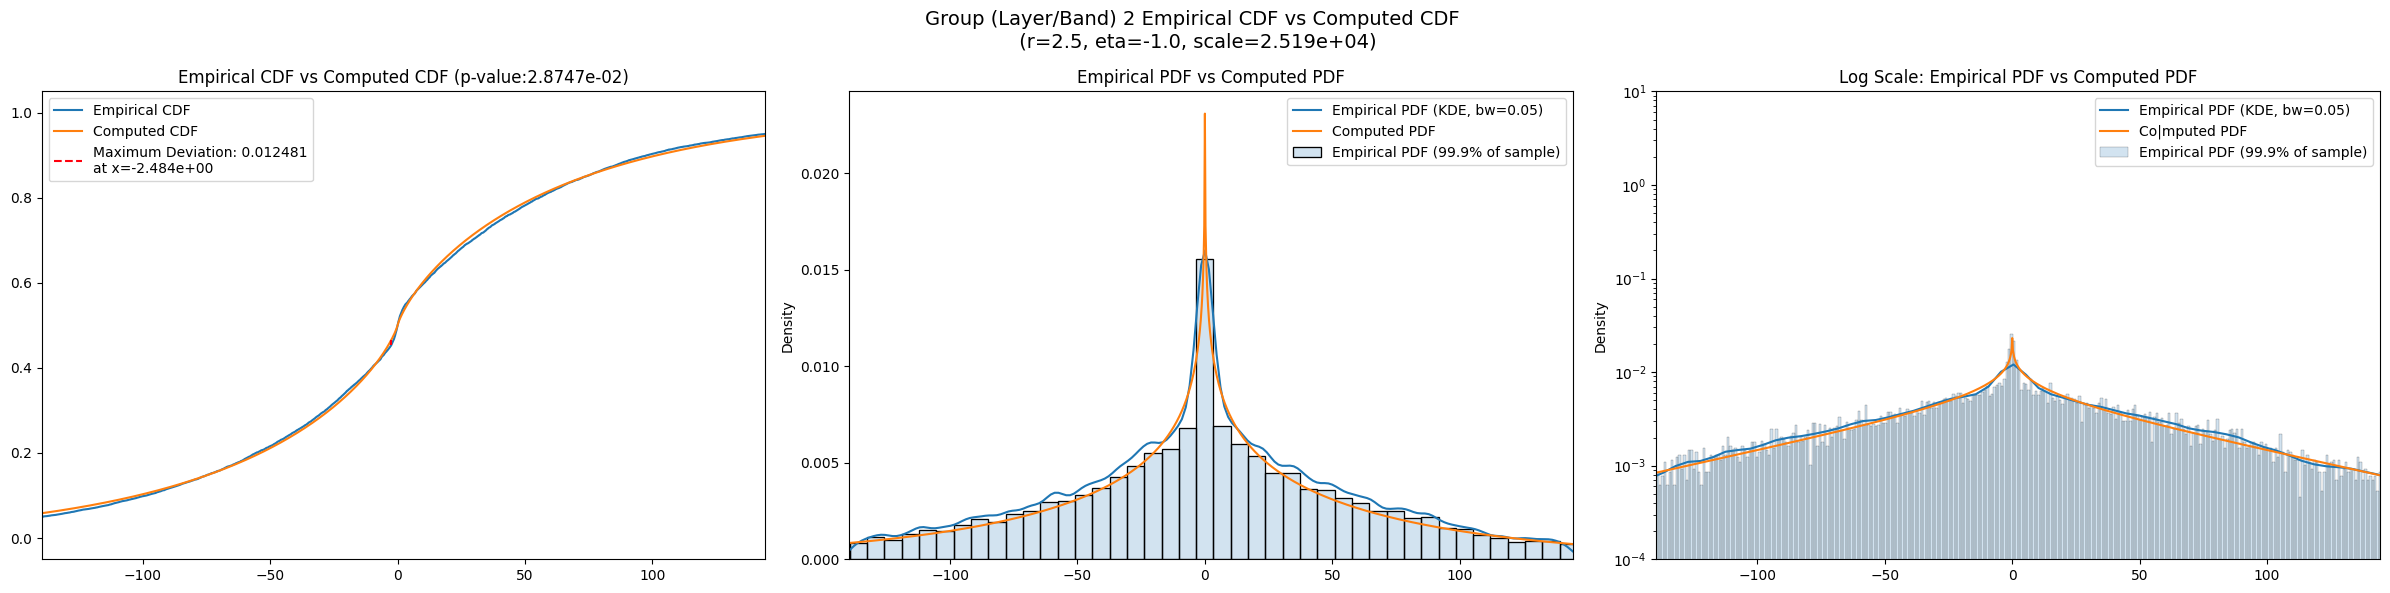

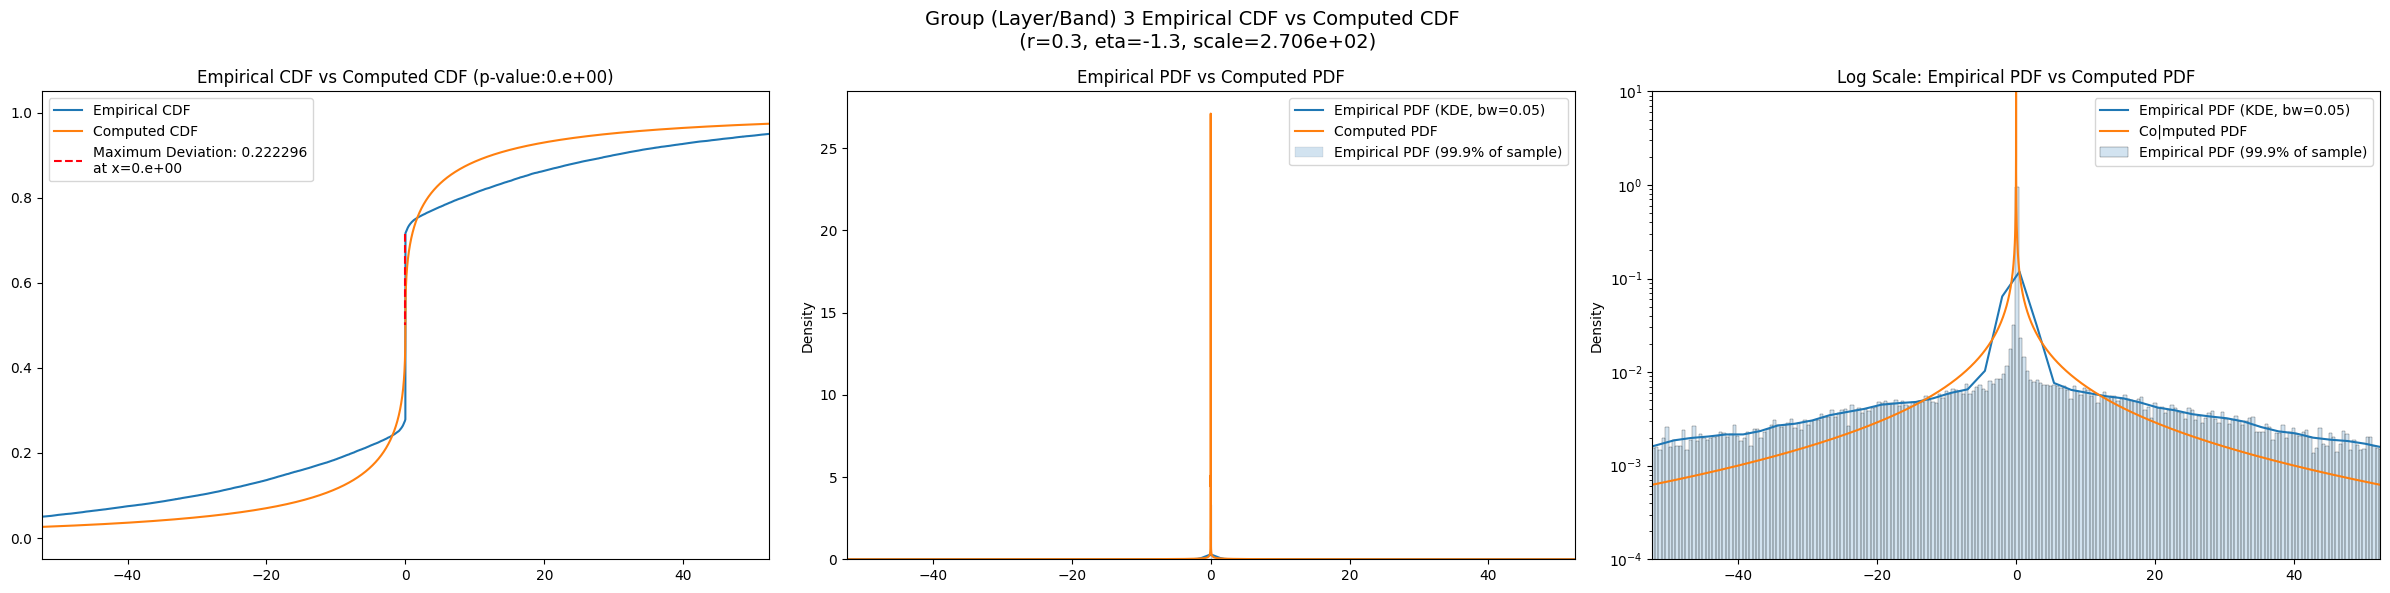

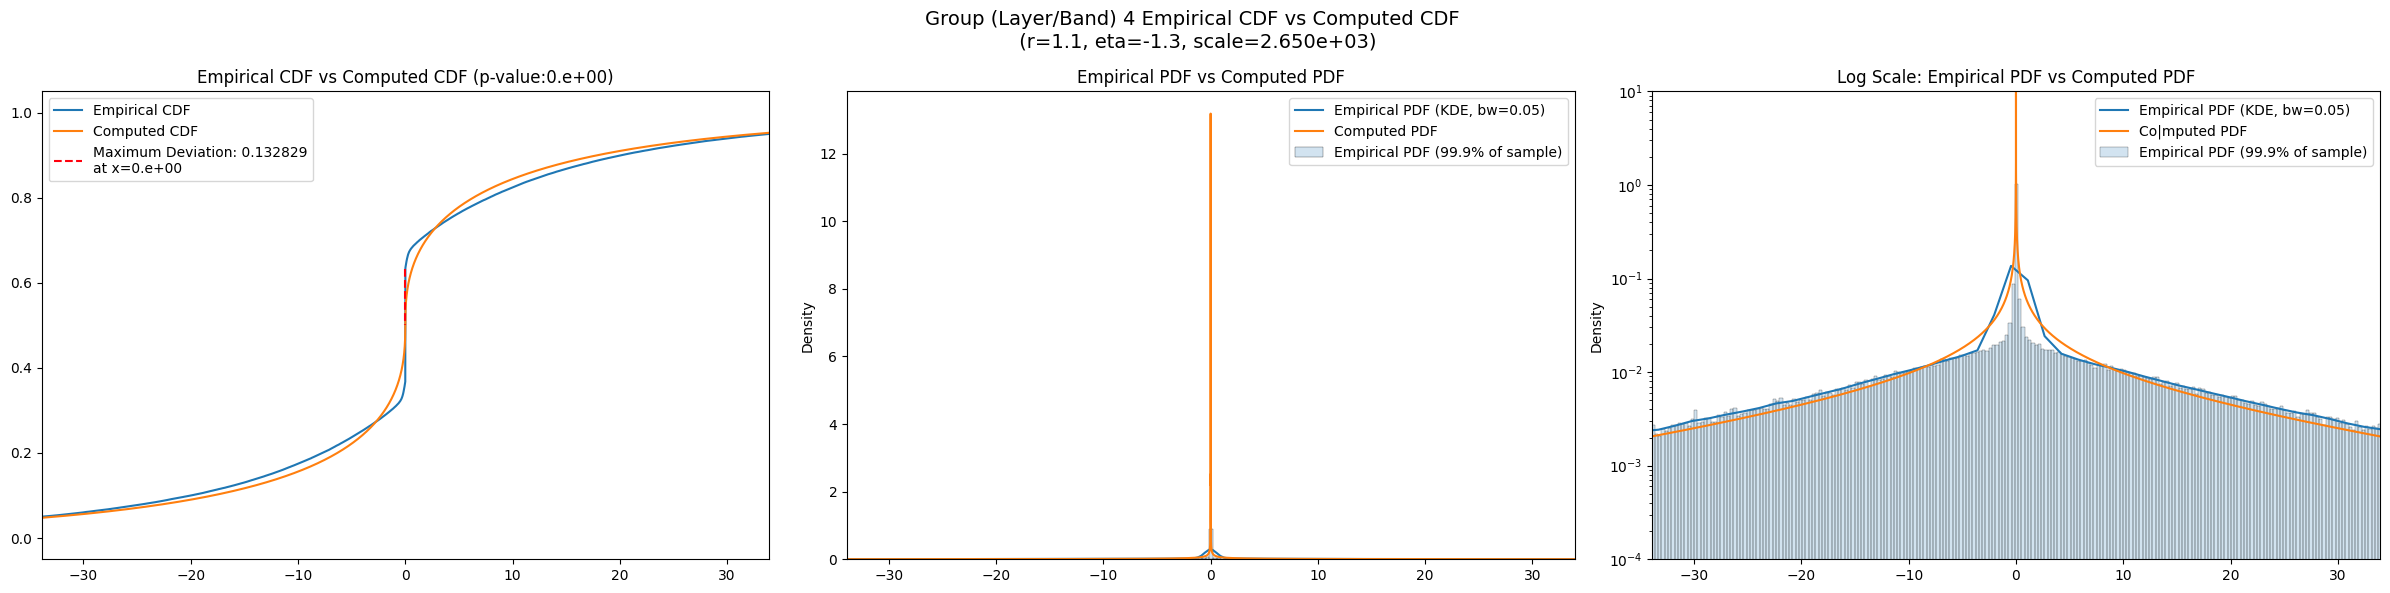

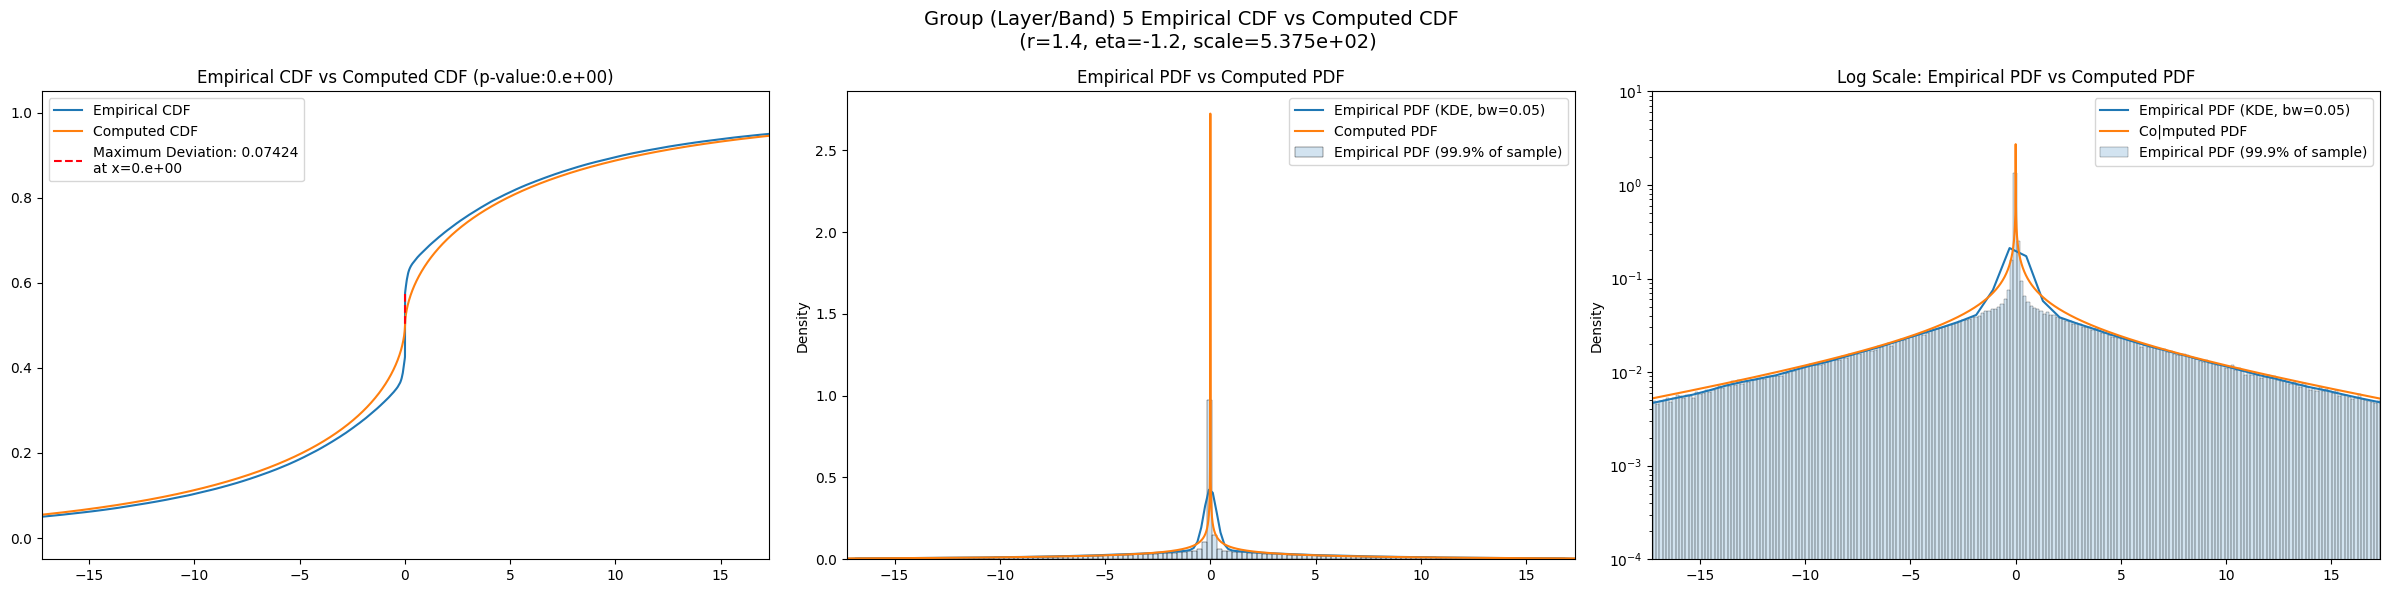

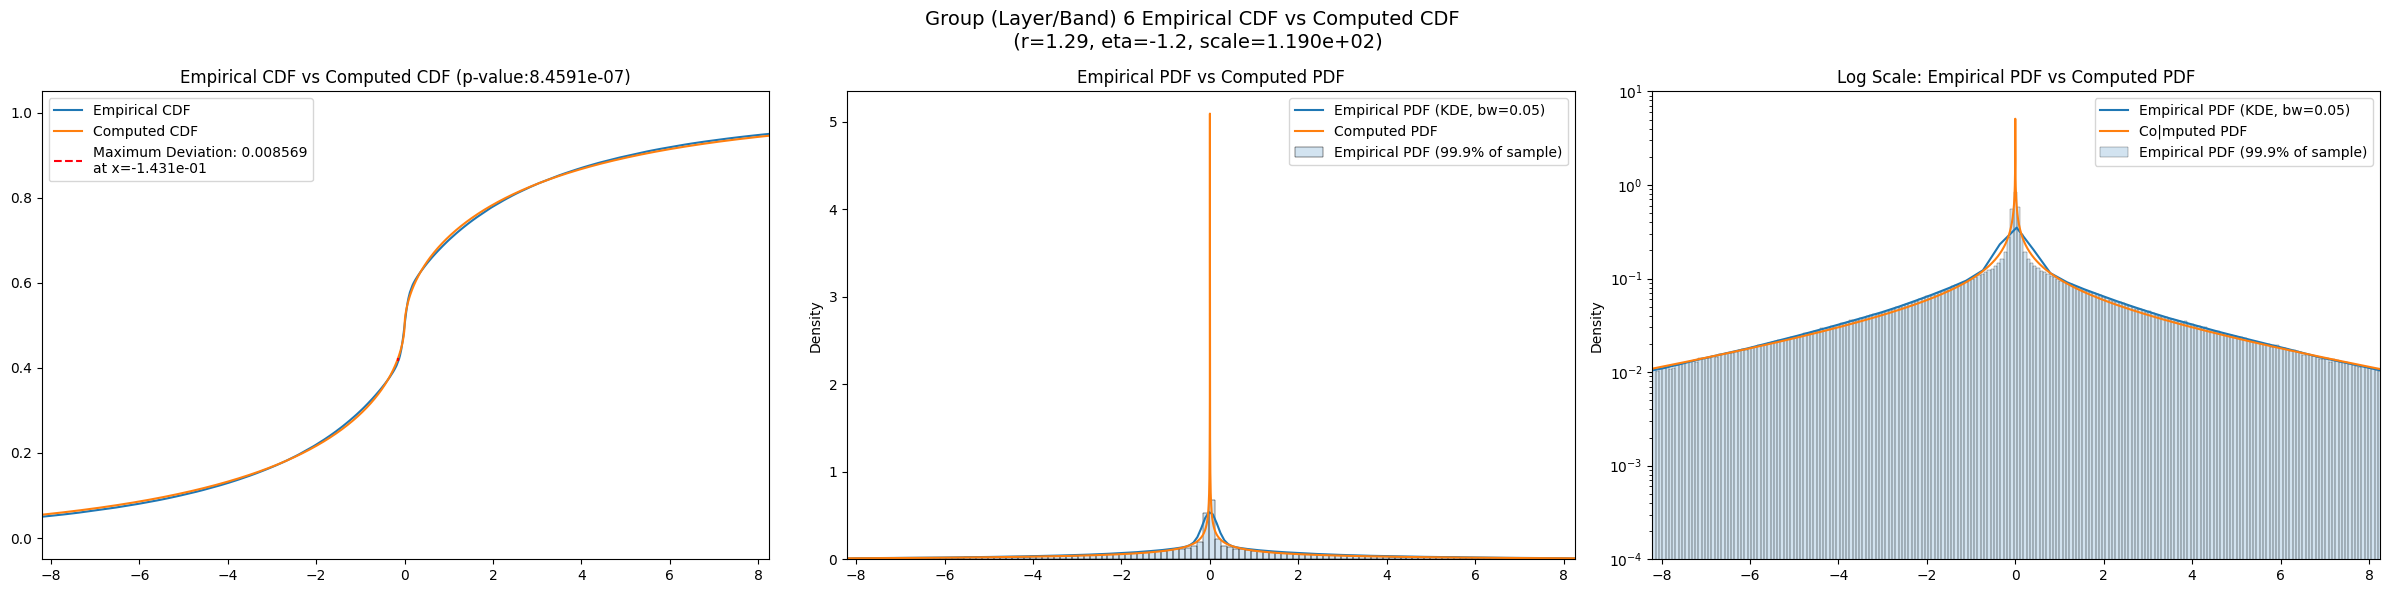

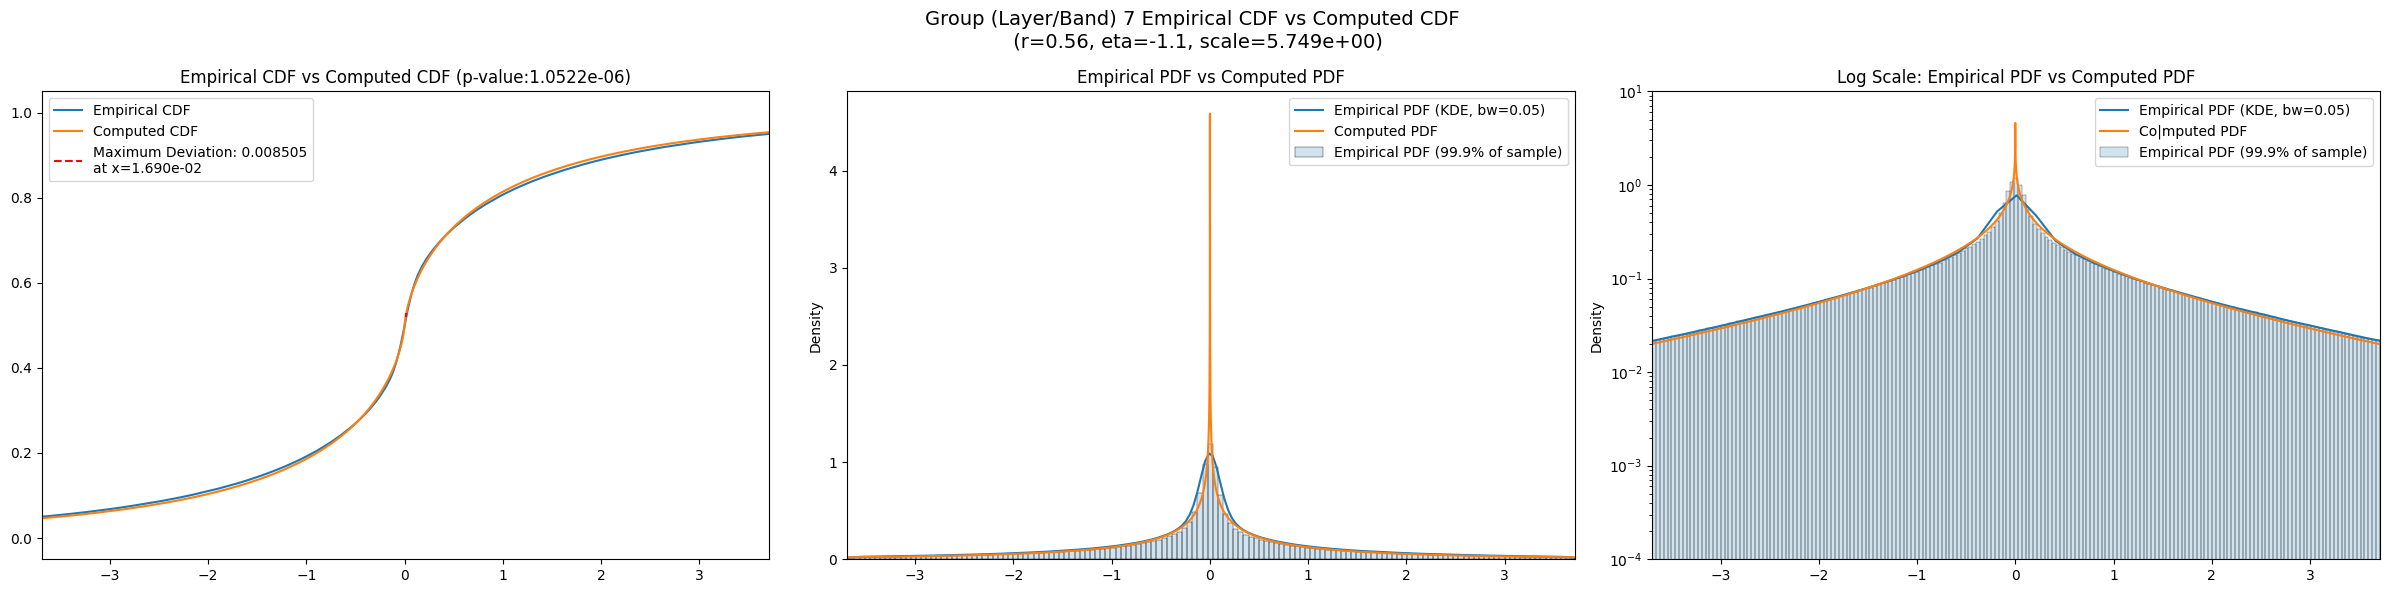

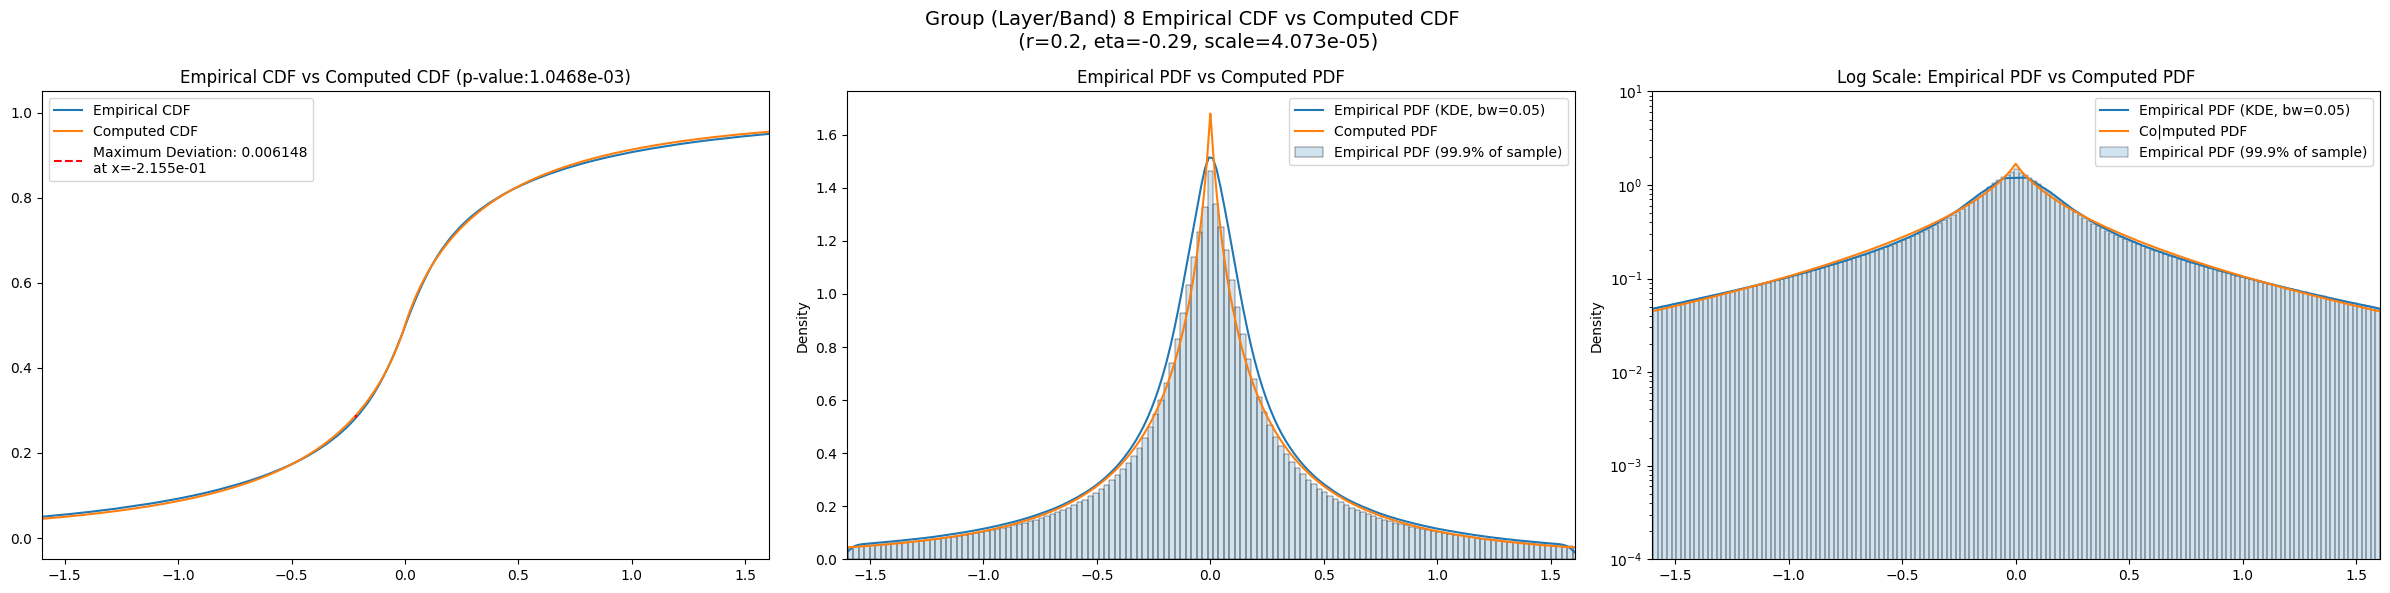

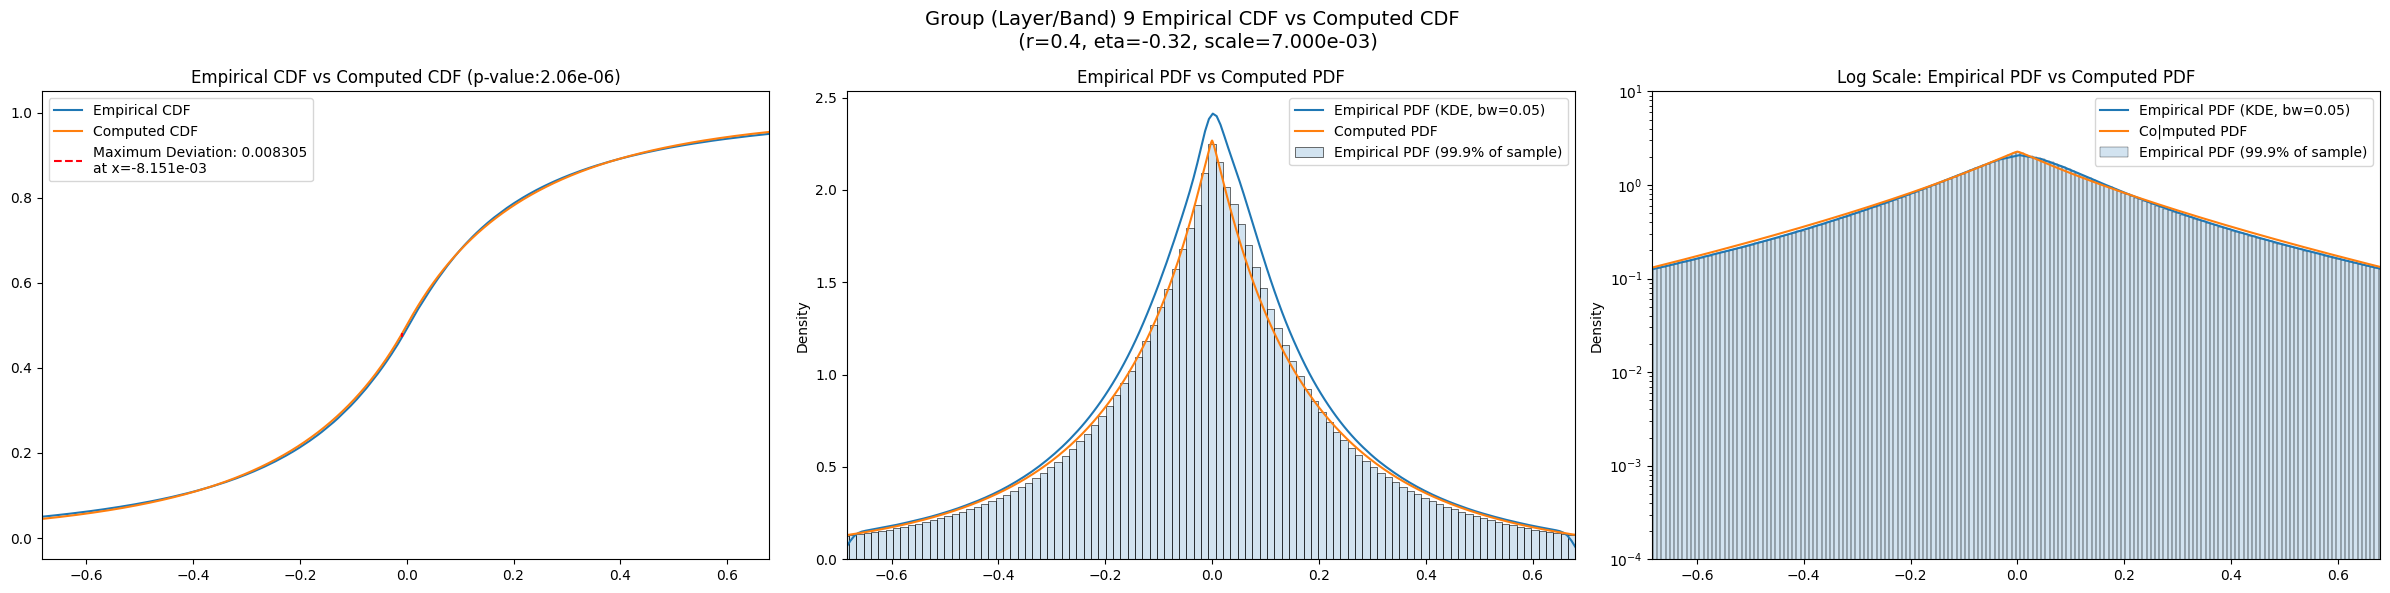

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
layer                                                                  
2      8170.624000  7603.631000  8790.542000    5.929228    3.575073   
3      1199.229000  1082.808500  1330.098100   14.136646    9.365142   
4       498.488830   450.375400   553.119700   13.649828    8.367245   
5       131.818250   119.407360   146.135670   13.324366    8.178824   
6        30.274773    27.387175    33.932415   15.115324    7.801616   
7         6.843550     6.050580     8.027263   27.543734   10.875002   
8         1.495765     1.261325     2.054993   94.259570   14.907044   
9         0.266803     0.216369     0.452525  294.651460   12.190354   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2        10.276577        13604.0             0.012452        2.5   
3        21.132668        54416.0             0.222067        0.3   
4        26.794820       166649.0             0.132690        1.1   
5        30.260353       574769.0             0.074170        1.4   
6        46.193558      2125625.0             0.008591        1.3   
7       106.769240      8502500.0             0.009396        0.6   
8       424.218260     34010000.0             0.006831        0.2   
9      1032.527700    136040000.0             0.008324        0.4   

       initial_eta  ...  param_gaussian  kstest_stat_gaussian  \
layer               ...                                         
2             -1.0  ...       65.375900              0.040167   
3             -1.3  ...        1.944660              0.222067   
4             -1.3  ...        5.325530              0.146686   
5             -1.2  ...        3.918870              0.111234   
6             -1.2  ...        2.678430              0.071936   
7             -1.1  ...        1.107610              0.077268   
8             -0.3  ...        0.539382              0.062930   
9             -0.3  ...        0.284076              0.045102   

       kstest_pval_gaussian  param_laplace  kstest_stat_laplace  \
layer                                                             
2              1.653940e-19      53.711400             0.024553   
3              0.000000e+00       1.464130             0.222067   
4              0.000000e+00       3.954650             0.136276   
5              0.000000e+00       3.006170             0.098878   
6              0.000000e+00       2.151070             0.053969   
7              0.000000e+00       0.935818             0.053157   
8              0.000000e+00       0.473935             0.035743   
9              0.000000e+00       0.250247             0.017965   

       kstest_pval_laplace    param_t  kstest_stat_t  kstest_pval_t  \
layer                                                                 
2             1.477480e-07  45.519900       0.028494   4.981950e-10   
3             0.000000e+00   1.053920       0.222067   0.000000e+00   
4             0.000000e+00   3.069600       0.137662   0.000000e+00   
5             0.000000e+00   2.400980       0.101488   0.000000e+00   
6             0.000000e+00   1.731040       0.057634   0.000000e+00   
7             0.000000e+00   0.738856       0.056007   0.000000e+00   
8             0.000000e+00   0.375139       0.035239   0.000000e+00   
9             0.000000e+00   0.197982       0.018724   0.000000e+00   

       kstest_pval_gengamma  
layer                        
2              2.919348e-02  
3              0.000000e+00  
4              0.000000e+00  
5              0.000000e+00  
6             1.878440e-133  
7              0.000000e+00  
8              0.000000e+00  
9              0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.012452                 0.011632          0.012452   
3                 0.222067                 0.005819          0.222067   
4                 0.132690                 0.003326          0.132690   
5                 0.074170                 0.001791          0.074170   
6                 0.008591                 0.000931          0.008488   
7                 0.009396                 0.000466          0.008530   
8                 0.006831                 0.000233          0.006541   
9                 0.008324                 0.000116          0.008287   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.040167             0.024553       0.028494  
3                  0.222067             0.222067       0.222067  
4                  0.146686             0.136276       0.137662  
5                  0.111234             0.098878       0.101488  
6                  0.071936             0.053969       0.057634  
7                  0.077268             0.053157       0.056007  
8                  0.062930             0.035743       0.035239  
9                  0.045102             0.017965       0.018724

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             8170.624000          0.012452    2.50     -1.00  25188.190411   
3             1199.229000          0.222067    0.30     -1.30    270.649585   
4              498.488830          0.132690    1.10     -1.30   2650.178029   
5              131.818250          0.074170    1.40     -1.20    537.492655   
6               30.274773          0.008488    1.29     -1.20    119.013126   
7                5.988860          0.008530    0.56     -1.10      5.748521   
8                1.272083          0.006541    0.20     -0.29      0.000041   
9                0.176970          0.008287    0.40     -0.32      0.007000   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                      0.0  
7                     75.0  
8                     50.0  
9                    300.0

In [21]:
eng.quit()